In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import itertools

# Importing Scikit-Learn libraries and packages
from numpy.random import seed
from tensorflow import set_random_seed
from sklearn.utils.fixes import signature
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#### Add random seeds so we can reproduce our results
#### (see https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)

In [31]:
seed(234)            # seed for Numpy
set_random_seed(234) # seed for Tensorflow

#### Set up model conditions for learning

In [32]:
#Values used with SGD
#learning_rate = 0.005
#batch_size_value = 1024
#epochs_value = 1000

learning_rate = 0.001
batch_size_value = 4096
epochs_value = 400  #350 #500  #200

momentum = 0.8

decay_rate = learning_rate / epochs_value
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

#### Import the dataset

In [33]:
dataset = pd.read_csv('ProjectData.csv',sep = '|', low_memory='FALSE')

In [34]:
dataset.shape

(818434, 87)

In [35]:
dataset = dataset.dropna()

In [36]:
dataset.shape

(818422, 87)

In [37]:
dataset.loc[:,'Age':'HCC138'].head()

,Age,Gender,IS_HOSPICE_FLAG,IS_SNP_FLAG,HCC1,HCC2,HCC6,HCC8,HCC9,HCC10,...,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189,HCC138
0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,83.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
dfRight = dataset.loc[:,'Age':'HCC138'].astype(int)

In [39]:
dfLeft = dataset.loc[:,'MMESource':'ID']

In [40]:
dataset = pd.concat([dfLeft,dfRight],axis=1,sort=False)

In [41]:
dataset.head()

,MMESource,BISource,ID,Age,Gender,IS_HOSPICE_FLAG,IS_SNP_FLAG,HCC1,HCC2,HCC6,...,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189,HCC138
0,2014.0,2014,202314VZWV,92,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,2014.0,2014,196726NMZP,83,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014.0,2014,541070LEZV,91,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014.0,2014,686694SVML,91,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2014.0,2014,698216GJPG,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Remove rows where all HCC values equal 0

In [42]:
dataset['All Zeros'] = dataset.loc[:,'HCC1':'HCC138'].sum(axis=1)

#### How many rows meet this condition?

In [43]:
dataset.loc[dataset['All Zeros'] == 0].shape

(10361, 88)

In [44]:
  dataset = dataset.drop(dataset[dataset['All Zeros']==0].index)

#### Check for any columns where all values are 0

In [45]:
dataset.loc[:,(dataset == 0).all(axis=0)].head()

,HCC138
0,0
1,0
2,0
3,0
4,0


#### Remove HCC138 column and 'All Zeros' columns

In [46]:
dataset = dataset.drop(['HCC138','All Zeros'], axis=1)

#### Chop data into a 1 year slice

In [47]:
dataset = dataset.loc[dataset['MMESource'] == 2016]
dataset.head(10)

,MMESource,BISource,ID,Age,Gender,IS_HOSPICE_FLAG,IS_SNP_FLAG,HCC1,HCC2,HCC6,...,HCC162,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189
290197,2016.0,2016,516823SENH,94,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
290198,2016.0,2016,593464OSUB,85,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290199,2016.0,2016,235815XWOR,93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290200,2016.0,2016,522003YDHY,93,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290201,2016.0,2016,296957RHRW,77,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290202,2016.0,2016,593124ISQR,78,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290203,2016.0,2016,785748DCOK,78,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290204,2016.0,2016,401581QNEI,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
290205,2016.0,2016,157244LTES,96,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290206,2016.0,2016,237072KSTP,94,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create matrix of features (X) 

In [48]:
X = dataset.drop(['MMESource','BISource','ID','HCC111'], axis=1)

#### Create matrix of target variable (y)

In [49]:
y = dataset.loc[:, ['HCC111']]
dataset[['HCC111']] = dataset[['HCC111']].astype('int')

In [50]:
X.shape

(244960, 82)

In [51]:
y.shape

(244960, 1)

#### Splitting the dataset into the Training set and Test set

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#### MOS Model

model = Sequential()
#model.add(Dropout(0.2, input_shape=(82,))) # dropout on the inputs (helps mimic noise or missing data)
model.add(Dense(82, input_dim=82, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(41, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.summary()

#### JCP Model

In [53]:
model = Sequential()
model.add(Dense(82, input_dim=82, activation='relu'))
model.add(Dense(41, kernel_regularizer=regularizers.l2(learning_rate), activation='relu'))
model.add(Dense(20, kernel_regularizer=regularizers.l2(learning_rate), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(learning_rate), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 82)                6806      
_________________________________________________________________
dense_7 (Dense)              (None, 41)                3403      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                840       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 11,270
Trainable params: 11,270
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

#### Checkpoint to save absolute best model

In [55]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

class_wts = class_weight.compute_class_weight(
            'balanced',
            np.unique(y), 
            y)

In [56]:
HCCModel = model.fit(X_train, 
                     y_train, 
                     batch_size=batch_size_value, 
                     epochs=epochs_value,
                     validation_data=(X_test, y_test),
                     callbacks=callbacks_list)
                     #class_weight='balanced')

Train on 171472 samples, validate on 73488 samples
Epoch 1/400
171472/171472 [==============================] - 7s 44us/step - loss: 0.7768 - acc: 0.5924 - val_loss: 0.7518 - val_acc: 0.7100

Epoch 00001: val_acc improved from -inf to 0.71005, saving model to weights-improvement-01-0.71.hdf5
Epoch 2/400
171472/171472 [==============================] - 8s 47us/step - loss: 0.7386 - acc: 0.7072 - val_loss: 0.7258 - val_acc: 0.7100

Epoch 00002: val_acc did not improve from 0.71005
Epoch 3/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.7165 - acc: 0.7072 - val_loss: 0.7070 - val_acc: 0.7100

Epoch 00003: val_acc did not improve from 0.71005
Epoch 4/400
171472/171472 [==============================] - 7s 44us/step - loss: 0.7001 - acc: 0.7072 - val_loss: 0.6927 - val_acc: 0.7100

Epoch 00004: val_acc did not improve from 0.71005
Epoch 5/400
171472/171472 [==============================] - 8s 46us/step - loss: 0.6875 - acc: 0.7072 - val_loss: 0.6814 - val_acc: 0

171472/171472 [==============================] - 6s 36us/step - loss: 0.5598 - acc: 0.7395 - val_loss: 0.5563 - val_acc: 0.7417

Epoch 00041: val_acc did not improve from 0.74190
Epoch 42/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5592 - acc: 0.7395 - val_loss: 0.5557 - val_acc: 0.7415

Epoch 00042: val_acc did not improve from 0.74190
Epoch 43/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5587 - acc: 0.7396 - val_loss: 0.5564 - val_acc: 0.7417

Epoch 00043: val_acc did not improve from 0.74190
Epoch 44/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5591 - acc: 0.7390 - val_loss: 0.5548 - val_acc: 0.7415

Epoch 00044: val_acc did not improve from 0.74190
Epoch 45/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5577 - acc: 0.7393 - val_loss: 0.5542 - val_acc: 0.7415

Epoch 00045: val_acc did not improve from 0.74190
Epoch 46/400
171472/171472 [=========================

171472/171472 [==============================] - 6s 36us/step - loss: 0.5503 - acc: 0.7398 - val_loss: 0.5463 - val_acc: 0.7419

Epoch 00082: val_acc did not improve from 0.74252
Epoch 83/400
171472/171472 [==============================] - 6s 38us/step - loss: 0.5504 - acc: 0.7399 - val_loss: 0.5456 - val_acc: 0.7425

Epoch 00083: val_acc improved from 0.74252 to 0.74253, saving model to weights-improvement-83-0.74.hdf5
Epoch 84/400
171472/171472 [==============================] - 7s 38us/step - loss: 0.5497 - acc: 0.7400 - val_loss: 0.5448 - val_acc: 0.7430

Epoch 00084: val_acc improved from 0.74253 to 0.74299, saving model to weights-improvement-84-0.74.hdf5
Epoch 85/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5494 - acc: 0.7400 - val_loss: 0.5451 - val_acc: 0.7421

Epoch 00085: val_acc did not improve from 0.74299
Epoch 86/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5494 - acc: 0.7400 - val_loss: 0.5445 - val_acc: 0.7


Epoch 00122: val_acc did not improve from 0.75686
Epoch 123/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5268 - acc: 0.7543 - val_loss: 0.5228 - val_acc: 0.7561

Epoch 00123: val_acc did not improve from 0.75686
Epoch 124/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5270 - acc: 0.7541 - val_loss: 0.5226 - val_acc: 0.7565

Epoch 00124: val_acc did not improve from 0.75686
Epoch 125/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5270 - acc: 0.7537 - val_loss: 0.5228 - val_acc: 0.7560

Epoch 00125: val_acc did not improve from 0.75686
Epoch 126/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5268 - acc: 0.7537 - val_loss: 0.5223 - val_acc: 0.7569

Epoch 00126: val_acc improved from 0.75686 to 0.75687, saving model to weights-improvement-126-0.76.hdf5
Epoch 127/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5263 - acc: 0.7543 - val_loss: 0.522

171472/171472 [==============================] - 6s 36us/step - loss: 0.5240 - acc: 0.7549 - val_loss: 0.5200 - val_acc: 0.7570

Epoch 00164: val_acc did not improve from 0.75717
Epoch 165/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5234 - acc: 0.7550 - val_loss: 0.5202 - val_acc: 0.7569

Epoch 00165: val_acc did not improve from 0.75717
Epoch 166/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5235 - acc: 0.7550 - val_loss: 0.5200 - val_acc: 0.7569

Epoch 00166: val_acc did not improve from 0.75717
Epoch 167/400
171472/171472 [==============================] - 7s 41us/step - loss: 0.5238 - acc: 0.7546 - val_loss: 0.5205 - val_acc: 0.7566

Epoch 00167: val_acc did not improve from 0.75717
Epoch 168/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5239 - acc: 0.7543 - val_loss: 0.5203 - val_acc: 0.7567

Epoch 00168: val_acc did not improve from 0.75717
Epoch 169/400
171472/171472 [====================


Epoch 00206: val_acc did not improve from 0.75717
Epoch 207/400
171472/171472 [==============================] - 7s 43us/step - loss: 0.5223 - acc: 0.7555 - val_loss: 0.5201 - val_acc: 0.7559

Epoch 00207: val_acc did not improve from 0.75717
Epoch 208/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5220 - acc: 0.7552 - val_loss: 0.5192 - val_acc: 0.7568

Epoch 00208: val_acc did not improve from 0.75717
Epoch 209/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5222 - acc: 0.7548 - val_loss: 0.5198 - val_acc: 0.7571

Epoch 00209: val_acc did not improve from 0.75717
Epoch 210/400
171472/171472 [==============================] - 7s 41us/step - loss: 0.5218 - acc: 0.7552 - val_loss: 0.5193 - val_acc: 0.7564

Epoch 00210: val_acc did not improve from 0.75717
Epoch 211/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5219 - acc: 0.7554 - val_loss: 0.5199 - val_acc: 0.7572

Epoch 00211: val_acc improved from


Epoch 00248: val_acc did not improve from 0.75724
Epoch 249/400
171472/171472 [==============================] - 6s 38us/step - loss: 0.5207 - acc: 0.7555 - val_loss: 0.5189 - val_acc: 0.7565

Epoch 00249: val_acc did not improve from 0.75724
Epoch 250/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5207 - acc: 0.7557 - val_loss: 0.5185 - val_acc: 0.7569

Epoch 00250: val_acc did not improve from 0.75724
Epoch 251/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5205 - acc: 0.7558 - val_loss: 0.5196 - val_acc: 0.7561

Epoch 00251: val_acc did not improve from 0.75724
Epoch 252/400
171472/171472 [==============================] - 6s 36us/step - loss: 0.5212 - acc: 0.7554 - val_loss: 0.5186 - val_acc: 0.7570

Epoch 00252: val_acc did not improve from 0.75724
Epoch 253/400
171472/171472 [==============================] - 6s 37us/step - loss: 0.5206 - acc: 0.7561 - val_loss: 0.5185 - val_acc: 0.7567

Epoch 00253: val_acc did not impro

171472/171472 [==============================] - 7s 40us/step - loss: 0.5200 - acc: 0.7557 - val_loss: 0.5198 - val_acc: 0.7567

Epoch 00290: val_acc did not improve from 0.75740
Epoch 291/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5198 - acc: 0.7560 - val_loss: 0.5182 - val_acc: 0.7572

Epoch 00291: val_acc did not improve from 0.75740
Epoch 292/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5202 - acc: 0.7558 - val_loss: 0.5187 - val_acc: 0.7568

Epoch 00292: val_acc did not improve from 0.75740
Epoch 293/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5198 - acc: 0.7561 - val_loss: 0.5185 - val_acc: 0.7571

Epoch 00293: val_acc did not improve from 0.75740
Epoch 294/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5198 - acc: 0.7559 - val_loss: 0.5182 - val_acc: 0.7570

Epoch 00294: val_acc did not improve from 0.75740
Epoch 295/400
171472/171472 [====================

171472/171472 [==============================] - 7s 39us/step - loss: 0.5193 - acc: 0.7562 - val_loss: 0.5193 - val_acc: 0.7567

Epoch 00332: val_acc did not improve from 0.75762
Epoch 333/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5193 - acc: 0.7564 - val_loss: 0.5187 - val_acc: 0.7572

Epoch 00333: val_acc did not improve from 0.75762
Epoch 334/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5193 - acc: 0.7562 - val_loss: 0.5180 - val_acc: 0.7568

Epoch 00334: val_acc did not improve from 0.75762
Epoch 335/400
171472/171472 [==============================] - 7s 41us/step - loss: 0.5186 - acc: 0.7565 - val_loss: 0.5185 - val_acc: 0.7569

Epoch 00335: val_acc did not improve from 0.75762
Epoch 336/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5185 - acc: 0.7564 - val_loss: 0.5182 - val_acc: 0.7571

Epoch 00336: val_acc did not improve from 0.75762
Epoch 337/400
171472/171472 [====================

171472/171472 [==============================] - 7s 39us/step - loss: 0.5174 - acc: 0.7570 - val_loss: 0.5179 - val_acc: 0.7572

Epoch 00374: val_acc did not improve from 0.75784
Epoch 375/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5177 - acc: 0.7570 - val_loss: 0.5181 - val_acc: 0.7575

Epoch 00375: val_acc did not improve from 0.75784
Epoch 376/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5179 - acc: 0.7571 - val_loss: 0.5193 - val_acc: 0.7573

Epoch 00376: val_acc did not improve from 0.75784
Epoch 377/400
171472/171472 [==============================] - 7s 39us/step - loss: 0.5175 - acc: 0.7572 - val_loss: 0.5191 - val_acc: 0.7572

Epoch 00377: val_acc did not improve from 0.75784
Epoch 378/400
171472/171472 [==============================] - 7s 40us/step - loss: 0.5178 - acc: 0.7574 - val_loss: 0.5179 - val_acc: 0.7575

Epoch 00378: val_acc did not improve from 0.75784
Epoch 379/400
171472/171472 [====================

In [57]:
model.save('HCCGuess.keras', overwrite = True)  

In [58]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

73488/73488 [==============================] - 4s 55us/step
Test loss: 0.5185356062402815
Test accuracy: 0.757089592858698


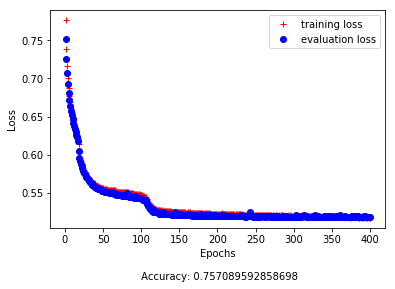

In [59]:
plt.plot(range(1,epochs_value+1), HCCModel.history['loss'], 'r+', label='training loss')
plt.plot(range(1,epochs_value+1), HCCModel.history['val_loss'], 'bo', label='evaluation loss')
plt.xlabel('Epochs\n\n Accuracy: '+str(score[1]))
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.75)

#### Compute SKLearn metrics

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.99      0.84     52180
           1       0.87      0.13      0.22     21308

   micro avg       0.74      0.74      0.74     73488
   macro avg       0.80      0.56      0.53     73488
weighted avg       0.77      0.74      0.66     73488



#### Plot Precision/Recall Curve

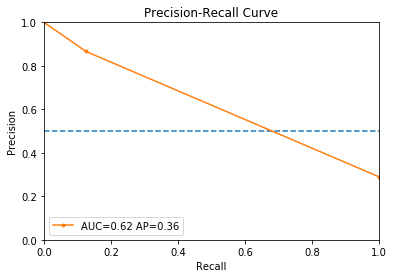

In [62]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
ap = average_precision_score(y_test, y_pred)

plt.clf()
plt.plot([0, 1], [0.5, 0.5], linestyle='--') # no skill
plt.plot(recall, precision, label='AUC=%0.2f AP=%0.2f' % (prc_auc, ap), marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

#### ROC Plot

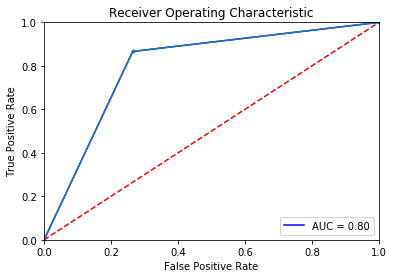

In [63]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.plot(fpr, tpr, marker='.')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Creating the Confusion Matrix

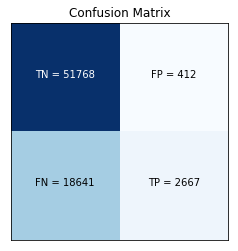

In [64]:
cm = confusion_matrix(y_test, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ''  #['Negative','Positive']
plt.title('Confusion Matrix')
#plt.ylabel('True COPD')
#plt.xlabel('Predicted COPD')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

fmt = 'd'
thresh = cm.max() / 2.

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

In [65]:
TN = cm[0,0]
FN = cm[1,0]
FP = cm[0,1]
TP = cm[1,1]

#### Calculate Fall-out aka False Positve Rate (Type I Error)

In [66]:
FP/(FP+TN)

0.007895745496358759

#### Calculate Miss Rate aka False Negative Rate (Type II Error)

In [67]:
FN/(TP+FN)

0.8748357424441524

#### Calculate Prevalence

In [68]:
(TP+FN)/(TP+FP+TN+FN)

0.2899521010232963